In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns 


C:\Users\rapha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
path = 'C:/Users/rapha/Documents/CNAM/HO/2A/Python_Times_Series/DataSet2.xlsx'

In [11]:
df = pd.read_excel(path, sheet_name='Feuil3')
df.tail()

,Date,Dernier,Ouv.,Plus Haut,Plus Bas
6199,2023-10-11,1.060479,1.060479,1.063355,1.059277
6200,2023-10-12,1.062428,1.062428,1.063909,1.054596
6201,2023-10-13,1.053674,1.053674,1.055855,1.049615
6202,2023-10-16,1.052155,1.052155,1.055465,1.051635
6203,2023-10-17,1.054519,1.056301,1.058089,1.053630


In [12]:
df.columns = ['Date','Cloture', 'Ouverture', 'Plus haut', 'Plus bas']



In [43]:
# Créez un DataFrame contenant la plage de dates
min_date = df['Date'].min()
max_date = df['Date'].max()
date_range = pd.date_range(start=min_date, end=max_date)
date_df = pd.DataFrame({'Date': date_range})

# Fusionnez les DataFrames en utilisant la colonne "Date" comme clé de fusion
merged_df = pd.merge(date_df, df, on='Date', how='left')

# Remplissez les valeurs manquantes avec les données appropriées
merged_df['Cloture'] = merged_df['Cloture'].fillna(method='ffill')
merged_df['Ouverture'] = merged_df['Ouverture'].rolling(window=3, min_periods=1).mean()
merged_df['Plus haut'] = merged_df['Plus haut'].rolling(window=3, min_periods=1).mean()
merged_df['Plus bas'] = merged_df['Plus bas'].rolling(window=3, min_periods=1).mean()


# Affichez le DataFrame final avec les lignes ajoutées pour les jours manquants
merged_df.head()
merged_df.drop('Ouverture', axis=1, inplace=True)
merged_df.drop('Plus haut', axis=1, inplace=True)
merged_df.drop('Plus bas', axis=1, inplace=True)
merged_df.head()
timeseries = merged_df["Cloture"].values.astype('float32')

In [44]:
merged_df.tail()

,Date,Cloture
8681,2023-10-13,1.053674
8682,2023-10-14,1.053674
8683,2023-10-15,1.053674
8684,2023-10-16,1.052155
8685,2023-10-17,1.054519


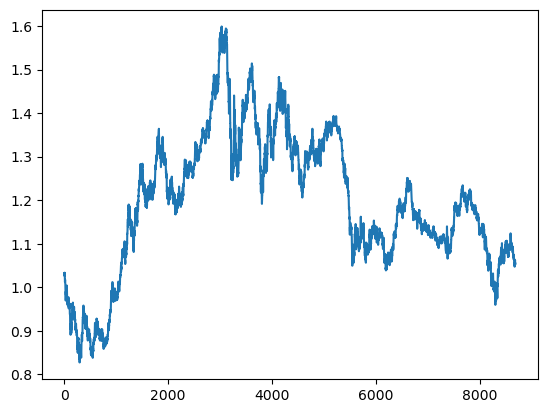

In [45]:
plt.plot(timeseries)
plt.show()
# Ordonnées : Clotures
# Abscisse : Time step

In [46]:
# Usually a time series should be “detrended” to remove the linear trend component and normalized before processing. For simplicity, these are skipped in this project.

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = merged_df["Cloture"].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [48]:
seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.1)

In [49]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [65]:
batch_size = 20

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/5
35/35 [==============================] - 41s 389ms/step - loss: 0.0011 - val_loss: 1.4786e-04
Epoch 2/5
35/35 [==============================] - 15s 433ms/step - loss: 4.8125e-04 - val_loss: 1.6445e-04
Epoch 3/5
35/35 [==============================] - 14s 400ms/step - loss: 6.0728e-04 - val_loss: 2.5873e-04
Epoch 4/5
35/35 [==============================] - 14s 413ms/step - loss: 8.5868e-04 - val_loss: 2.8616e-04
Epoch 5/5
35/35 [==============================] - 15s 434ms/step - loss: 6.7496e-04 - val_loss: 1.5564e-04


243/243 [==============================] - 50s 184ms/step


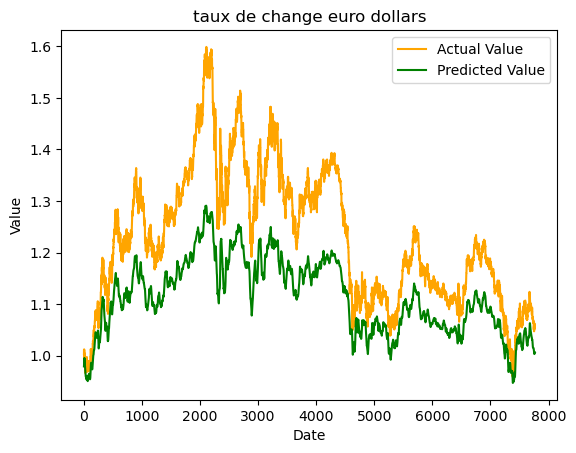

In [66]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Value', color='orange')
plt.plot(y_pred_orig, label='Predicted Value', color='green')
 
plt.title('taux de change euro dollars')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')

plt.show();

In [59]:
n_rows_90_percent = 7765

# Sélectionner les premières 90% lignes pour le nouveau DataFrame
df_90_percent = merged_df.tail(n_rows_90_percent)

# Afficher les premières lignes du nouveau DataFrame
print(df_90_percent)
len(df_90_percent)


           Date   Cloture
921  2002-07-15  1.003000
922  2002-07-16  1.011600
923  2002-07-17  1.007200
924  2002-07-18  1.011800
925  2002-07-19  1.011600
...         ...       ...
8681 2023-10-13  1.053674
8682 2023-10-14  1.053674
8683 2023-10-15  1.053674
8684 2023-10-16  1.052155
8685 2023-10-17  1.054519

[7765 rows x 2 columns]


7765

In [60]:
df_90_percent["Prediction"] = y_pred_orig

df_90_percent.tail()

C:\Users\rapha\AppData\Local\Temp\ipykernel_28244\1746225333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_percent["Prediction"] = y_pred_orig


,Date,Cloture,Prediction
8681,2023-10-13,1.053674,1.030506
8682,2023-10-14,1.053674,1.030684
8683,2023-10-15,1.053674,1.030779
8684,2023-10-16,1.052155,1.030778
8685,2023-10-17,1.054519,1.030686


In [61]:
df_90_percent["Ecart"] = df_90_percent["Prediction"] - df_90_percent["Cloture"]
print(df_90_percent)

           Date   Cloture  Prediction     Ecart
921  2002-07-15  1.003000    0.976919 -0.026081
922  2002-07-16  1.011600    0.977987 -0.033613
923  2002-07-17  1.007200    0.979496 -0.027704
924  2002-07-18  1.011800    0.981166 -0.030634
925  2002-07-19  1.011600    0.983035 -0.028565
...         ...       ...         ...       ...
8681 2023-10-13  1.053674    1.030506 -0.023168
8682 2023-10-14  1.053674    1.030684 -0.022990
8683 2023-10-15  1.053674    1.030779 -0.022895
8684 2023-10-16  1.052155    1.030778 -0.021377
8685 2023-10-17  1.054519    1.030686 -0.023833

[7765 rows x 4 columns]


C:\Users\rapha\AppData\Local\Temp\ipykernel_28244\1516014793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_percent["Ecart"] = df_90_percent["Prediction"] - df_90_percent["Cloture"]


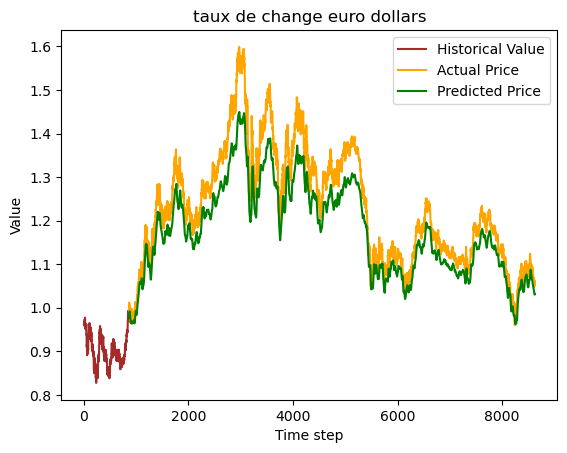

,Date,Cloture
0,2000-01-06,1.0324
1,2000-01-07,1.0292
2,2000-01-08,1.0292
3,2000-01-09,1.0292
4,2000-01-10,1.0257


In [62]:
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Value')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('taux de change euro dollars')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show();
merged_df.head()